# [实验三报告](https://github.com/YuweiWen1217/2024-MachineLearning)
文昱韦 2213125

#### 实验三：参数估计和非参数估计
1. **初级要求**：生成两个各包含 $N=1000$ 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量 $\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$ 和协方差矩阵 $D_1=D_2=D_3=2\pmb{I}$ ，其中$\pmb{I}$是 $2*2$的单位矩阵。在生成数据集合 $X_1$ 时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1)=0.6$，$p(w_2)=0.3$，$p(w_3)=0.1$。在两个数据集合上分别应用“似然率测试规则”和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。
2. **中级要求**：在两个数据集合上使⽤高斯核函数估计方法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果。
3. **高级要求**：在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析$k=1，3，5$时的概率密度估计结果。

##### 数据分析
本次实验共有两个数据集$X_1$、$X_2$，每个数据集包含1000个数据，一个数据是一个二维向量（特征数为2）。这些向量来自三个分布模型，均值分别是$\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$，每个分布的协方差矩阵均为 $\begin{bmatrix} 2 & 0 \\ 0 & 2 \end{bmatrix}$，意味着两个特征之间是独立的，且每个特征的方差为2。$X_1$中，三个分布的先验概率均为$\frac{1}{3}$，即数据均匀的在三个分布的均值点附近出现；$X_2$中，先验概率分别为0.6、0.3、0.1，意味着第一个分布均值附近的点较多一些，第三个分布均值附近的点最少。我们运行下面的代码，按要求生成这两个数据集，可以通过绘制的图中看出这些特点。

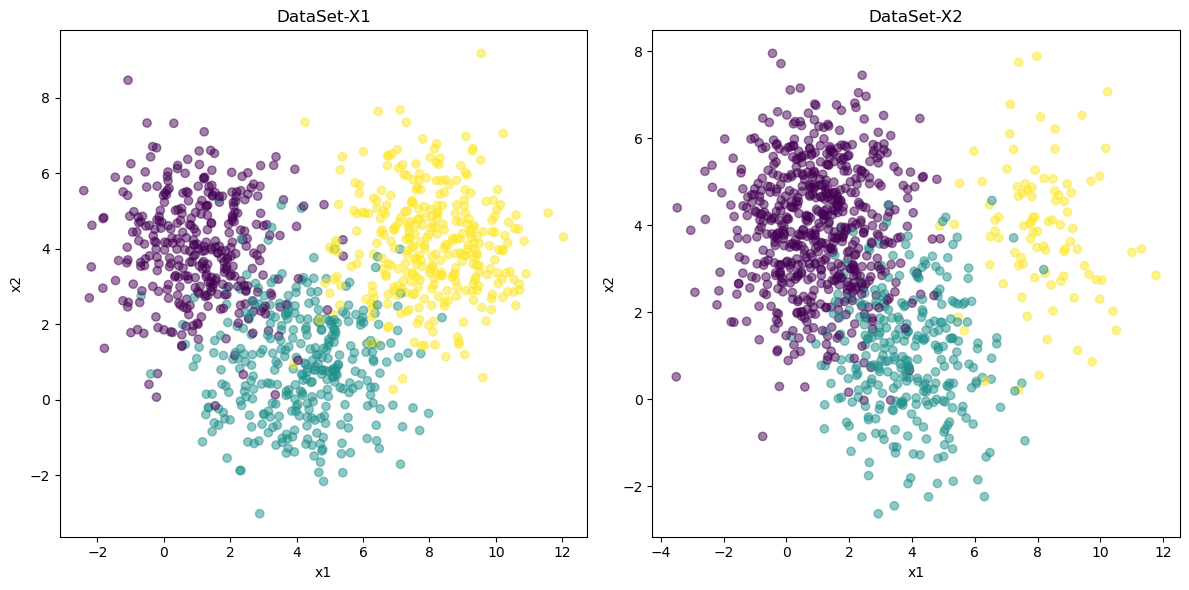

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.neighbors import NearestNeighbors

# 设置参数：样本数量、均值、协方差矩阵
N = 1000
mu_1 = np.array([1, 4])
mu_2 = np.array([4, 1])
mu_3 = np.array([8, 4])
cov = 2 * np.eye(2)


# 生成数据集 X1 函数
def generatedata(N, dataset):
    # labels:数据点对应的分布；X1/X2：数据点
    if dataset == '1':
        labels = np.random.choice([0, 1, 2], size=N)
    else:
        prior_probs = [0.6, 0.3, 0.1]
        labels = np.random.choice([0, 1, 2], size=N, p=prior_probs)  
    X1 = np.zeros((N, 2))
    for i in range(N):
        # 生成不同均值、方差为2的二维随机向量
        if labels[i] == 0:
            X1[i] = np.random.multivariate_normal(mu_1, cov)
        elif labels[i] == 1:
            X1[i] = np.random.multivariate_normal(mu_2, cov)
        else:
            X1[i] = np.random.multivariate_normal(mu_3, cov)
    return X1, labels


# 生成两个数据集
X1, labels1 = generatedata(N,'1')
X2, labels2 = generatedata(N,'2')

# 可视化两个数据集
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X1[:, 0], X1[:, 1], c=labels1, cmap='viridis', alpha=0.5)
plt.title('DataSet-X1')
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(1, 2, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=labels2, cmap='viridis', alpha=0.5)
plt.title('DataSet-X2')
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()
plt.show()


##### 初级要求
对于数据集中的每一个数据点，首先计算这个数据点在三种正态分布下的概率密度。对于“似然率测试规则”，我们选择$P(X|\theta)$最大者，即计算得到的三个概率密度中的最大者作为分类依据；对于“最大后验概率规则”，我们需要选择$P(\theta|X)$中的最大者作为分类依据，$P(\theta|X)$正比于$P(X|\theta) \times P(\theta)$，于是我们将得到的概率密度乘以对应的分布概率，然后从中选择最大值对应的分布即可。最后分类完所有的数据点后，计算两个数据集下、两种方法的错误率。

In [2]:
# 计算x在三种正态分布下的概率密度
def density(x):
    return [
        multivariate_normal.pdf(x, mean=mu_1, cov=cov),
        multivariate_normal.pdf(x, mean=mu_2, cov=cov),
        multivariate_normal.pdf(x, mean=mu_3, cov=cov)
    ]

# 进行分类
def classify(X, dataset = '1'):
    predictions_MLE = []
    predictions_MAP = []
    for x in X:
        # densities：一个向量，x在三种正态分布下的概率密度。
        densities = density(x)
        # 似然率测试规则：直接选择P(X|\theta)最大者
        predictions_MLE.append(np.argmax(densities))
        # 最大后验概率规则：选择P(\theta|X)最大者
        if dataset == '1':
            priors = [1/3, 1/3, 1/3]
        else:
            priors = [0.6, 0.3, 0.1]
        posterior = [densities[i] * priors[i] for i in range(3)]
        predictions_MAP.append(np.argmax(posterior))
    return predictions_MLE, predictions_MAP

# 计算错误率
def calculate_error_rate(predictions, true_labels):
    return np.mean(np.array(predictions) != np.array(true_labels))

print("初级要求")

# 应用两种方法进行分类
predictions_X1_MLE, predictions_X1_MAP = classify(X1, dataset ='1') 
predictions_X2_MLE, predictions_X2_MAP = classify(X2, dataset ='2')

# 计算错误率
error_rate_X1_MLE = calculate_error_rate(predictions_X1_MLE, labels1)
error_rate_X1_MAP = calculate_error_rate(predictions_X1_MAP, labels1)

error_rate_X2_MLE = calculate_error_rate(predictions_X2_MLE, labels2)
error_rate_X2_MAP = calculate_error_rate(predictions_X2_MAP, labels2)

# 输出结果
print("X1数据集的分类错误率:")
print(f"似然率测试规则: {error_rate_X1_MLE:.4f}")
print(f"最大后验概率规则: {error_rate_X1_MAP:.4f}")

print("\nX2数据集的分类错误率:")
print(f"似然率测试规则: {error_rate_X2_MLE:.4f}")
print(f"最大后验概率规则: {error_rate_X2_MAP:.4f}")

初级要求
X1数据集的分类错误率:
似然率测试规则: 0.0780
最大后验概率规则: 0.0780

X2数据集的分类错误率:
似然率测试规则: 0.0800
最大后验概率规则: 0.0710


根据结果可以发现，由于X1数据集中，三个分布的先验概率相同，两种方法在本质上没有任何区别，错误率也必然相同；对于X2数据集，引入了先验概率后，从得到的最大后验概率中选择分类的分布，显著地降低了错误率。

##### 中级要求

利用高斯核函数进行概率密度估计的公式是：
$$
\hat{p}(x)=\frac{1}{\sqrt[]{2\pi} Nh}\sum_{i=1}^{N}\text{exp}(-\frac{(x-x_i)^2}{2h^2} )
$$

在这个式子中，样本中的每一个数据点都会对x产生影响，并且随着两点距离的增大而平滑减小。其中，$h$为窗口宽度，决定了影响的宽度。

为了使用高斯核函数进行概率密度估计，我们对每一个数据点分别计算它与其他每个类别中的数据点的核函数值，根据公式生成三个概率密度，这分别对应不同的三种类别，然后再采用初级要求中使用过的两种方法进行分类，计算错误率。

数据集合 X1 的错误率:
h=0.1: 最大似然估计错误率 = 0.1090, 最大后验概率估计错误率 = 0.1090
h=0.5: 最大似然估计错误率 = 0.0820, 最大后验概率估计错误率 = 0.0820
h=1: 最大似然估计错误率 = 0.0830, 最大后验概率估计错误率 = 0.0830
h=1.5: 最大似然估计错误率 = 0.0840, 最大后验概率估计错误率 = 0.0840
h=2: 最大似然估计错误率 = 0.0840, 最大后验概率估计错误率 = 0.0840

数据集合 X2 的错误率:
h=0.1: 最大似然估计错误率 = 0.6950, 最大后验概率估计错误率 = 0.5520
h=0.5: 最大似然估计错误率 = 0.7500, 最大后验概率估计错误率 = 0.3970
h=1: 最大似然估计错误率 = 0.8240, 最大后验概率估计错误率 = 0.3920
h=1.5: 最大似然估计错误率 = 0.8660, 最大后验概率估计错误率 = 0.3900
h=2: 最大似然估计错误率 = 0.8810, 最大后验概率估计错误率 = 0.3900


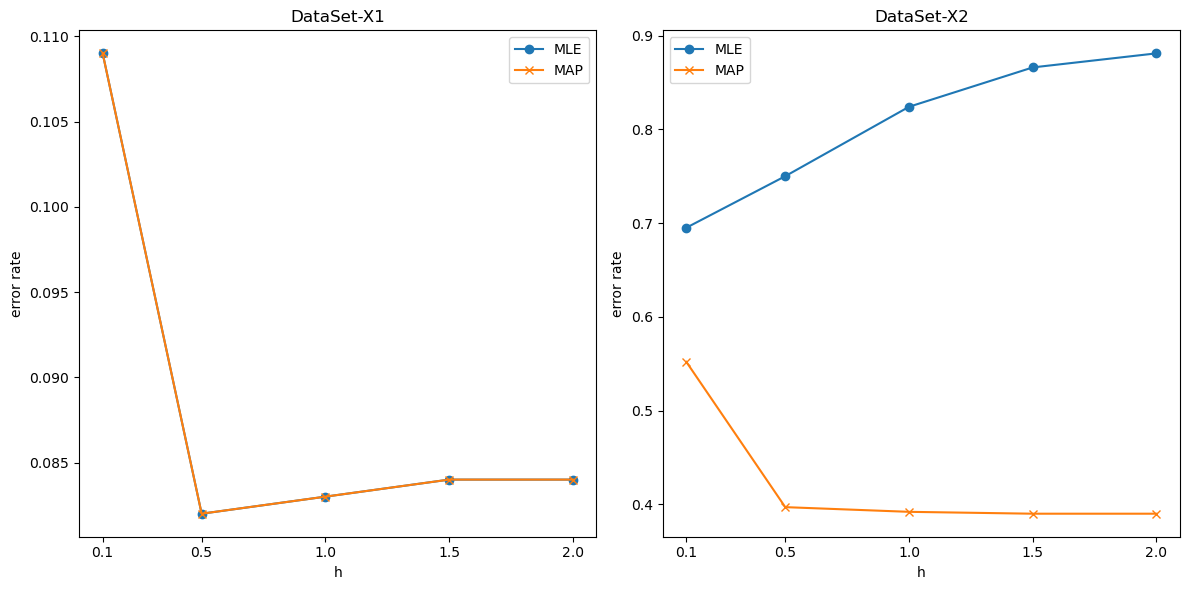

In [3]:
# 高斯核函数，计算样本x和数据点xi之间的高斯核值，h为窗口宽度。
def gaussian_kernel(x, x_i, h):
    return np.exp(-0.5 * np.sum((x - x_i) ** 2) / h**2) / (h * np.sqrt(2 * np.pi))

# x的核函数概率密度估计
def kernel_density_estimate(X, x, h):
    return np.mean([gaussian_kernel(x, x_i, h) for x_i in X])


# 分类
def classify_with_kernel(X, labels, h, dataset):
    predictions_MLE = []
    predictions_MAP = []
    for idx, x in enumerate(X):
        # 生成训练集，排除当前样本
        X_train = np.delete(X, idx, axis=0)
        labels_train = np.delete(labels, idx)
        # 计算每个类别的核密度估计
        densities = []
        for i in range(3):
            class_samples = X_train[labels_train == i]
            density = kernel_density_estimate(class_samples, x, h)
            densities.append(density)

        # 重复初级要求的分类过程
        predictions_MLE.append(np.argmax(densities))
        if dataset == '1':
            priors = [1/3, 1/3, 1/3]
        else:
            priors = [0.6, 0.3, 0.1]
        posterior = [densities[i] * priors[i] for i in range(3)]
        predictions_MAP.append(np.argmax(posterior))
    return predictions_MLE, predictions_MAP



h_values = [0.1, 0.5, 1, 1.5, 2]
results_X1_MLE = {}
results_X2_MLE = {}
results_X1_MAP = {}
results_X2_MAP = {}

for h in h_values:
    # X1 分类
    predictions_X1_MLE, predictions_X1_MAP = classify_with_kernel(X1, labels1, h, '1')
    error_rate_X1_MLE = calculate_error_rate(predictions_X1_MLE, labels1)
    error_rate_X1_MAP = calculate_error_rate(predictions_X1_MAP, labels1)
    results_X1_MLE[h] = error_rate_X1_MLE
    results_X1_MAP[h] = error_rate_X1_MAP

    # X2 分类
    predictions_X2_MLE, predictions_X2_MAP = classify_with_kernel(X2, labels1, h, '2')
    error_rate_X2_MLE = calculate_error_rate(predictions_X2_MLE, labels2)
    error_rate_X2_MAP = calculate_error_rate(predictions_X2_MAP, labels2)
    results_X2_MLE[h] = error_rate_X2_MLE
    results_X2_MAP[h] = error_rate_X2_MAP

# 输出错误率结果
print("数据集合 X1 的错误率:")
for h in h_values:
    print(f"h={h}: 最大似然估计错误率 = {results_X1_MLE[h]:.4f}, 最大后验概率估计错误率 = {results_X1_MAP[h]:.4f}")

print("\n数据集合 X2 的错误率:")
for h in h_values:
    print(f"h={h}: 最大似然估计错误率 = {results_X2_MLE[h]:.4f}, 最大后验概率估计错误率 = {results_X2_MAP[h]:.4f}")

# 可视化输出
plt.figure(figsize=(12, 6))

# X1 错误率可视化
plt.subplot(1, 2, 1)
plt.plot(h_values, list(results_X1_MLE.values()), marker='o', label='MLE')
plt.plot(h_values, list(results_X1_MAP.values()), marker='x', label='MAP')
plt.title('DataSet-X1')
plt.xlabel('h')
plt.ylabel('error rate')
plt.xticks(h_values)
plt.legend()

# X2 错误率可视化
plt.subplot(1, 2, 2)
plt.plot(h_values, list(results_X2_MLE.values()), marker='o', label='MLE')
plt.plot(h_values, list(results_X2_MAP.values()), marker='x', label='MAP')
plt.title('DataSet-X2')
plt.xlabel('h')
plt.ylabel('error rate')
plt.xticks(h_values)
plt.legend()

plt.tight_layout()
plt.show()

我们将不同窗口大小h所得到的分类错误率绘制成上图。首先可以得到初级要求中的一个结论，即对于三个分布的先验概率相同的数据集$X_1$，两种方法得到的分类结果相同，表现出来的错误率也相同；对于先验概率不同的数据集$X_2$，MAP的表现较为优异一点。在本小题中，我们测试了5个不同的窗口大小h，结合图像和数据，发现对于$X_1$，最优的$h$值为0.5；对于$X_2$，最优的$h$值为2（最大后验概率规则分类）。值得注意的是，我们经过了多次实验，发现每次实验所得到的最优$h$值有所不同，这意味着不同数据集会影响分类效果。

#### 高级要求
我对本题的理解是，应用kNN概率密度估计方法，给出任意向量$(x_1,x_2)$的概率密度估计值。即前两个小题是计算一个点在数据集中的每个分布的概率密度估计，然后根据求得的三个概率密度估计值进行分类，判断其应该属于哪一个具体分布；本小题不再区分这三个具体的分布，而是求一个点在整个数据集中的概率密度估计值。

kNN的概率密度公式为：
$$
\hat{p}(x)=\frac{k}{2Nd_k(x)}
$$

其中，$2d_k(x)$指的是距离点$x$最近的**第**$k$个点到点$x$的距离（一维里，覆盖$x$点左右两边，因此乘以2）。在本题中，我们是二维的，因此$2d_k(x)$应当成为以$x$点为圆心、两点间距离为半径形成的圆的面积。

需要特别处理的是，当$k=1$时，如果点$x$恰好和数据集中某点重合，会导致分母为0，即导致概率密度曲线不连续，此时我们直接赋值为1即可。

最后我们呈现出来的是两个数据集下不同$k$值情况下的概率密度估计图像。

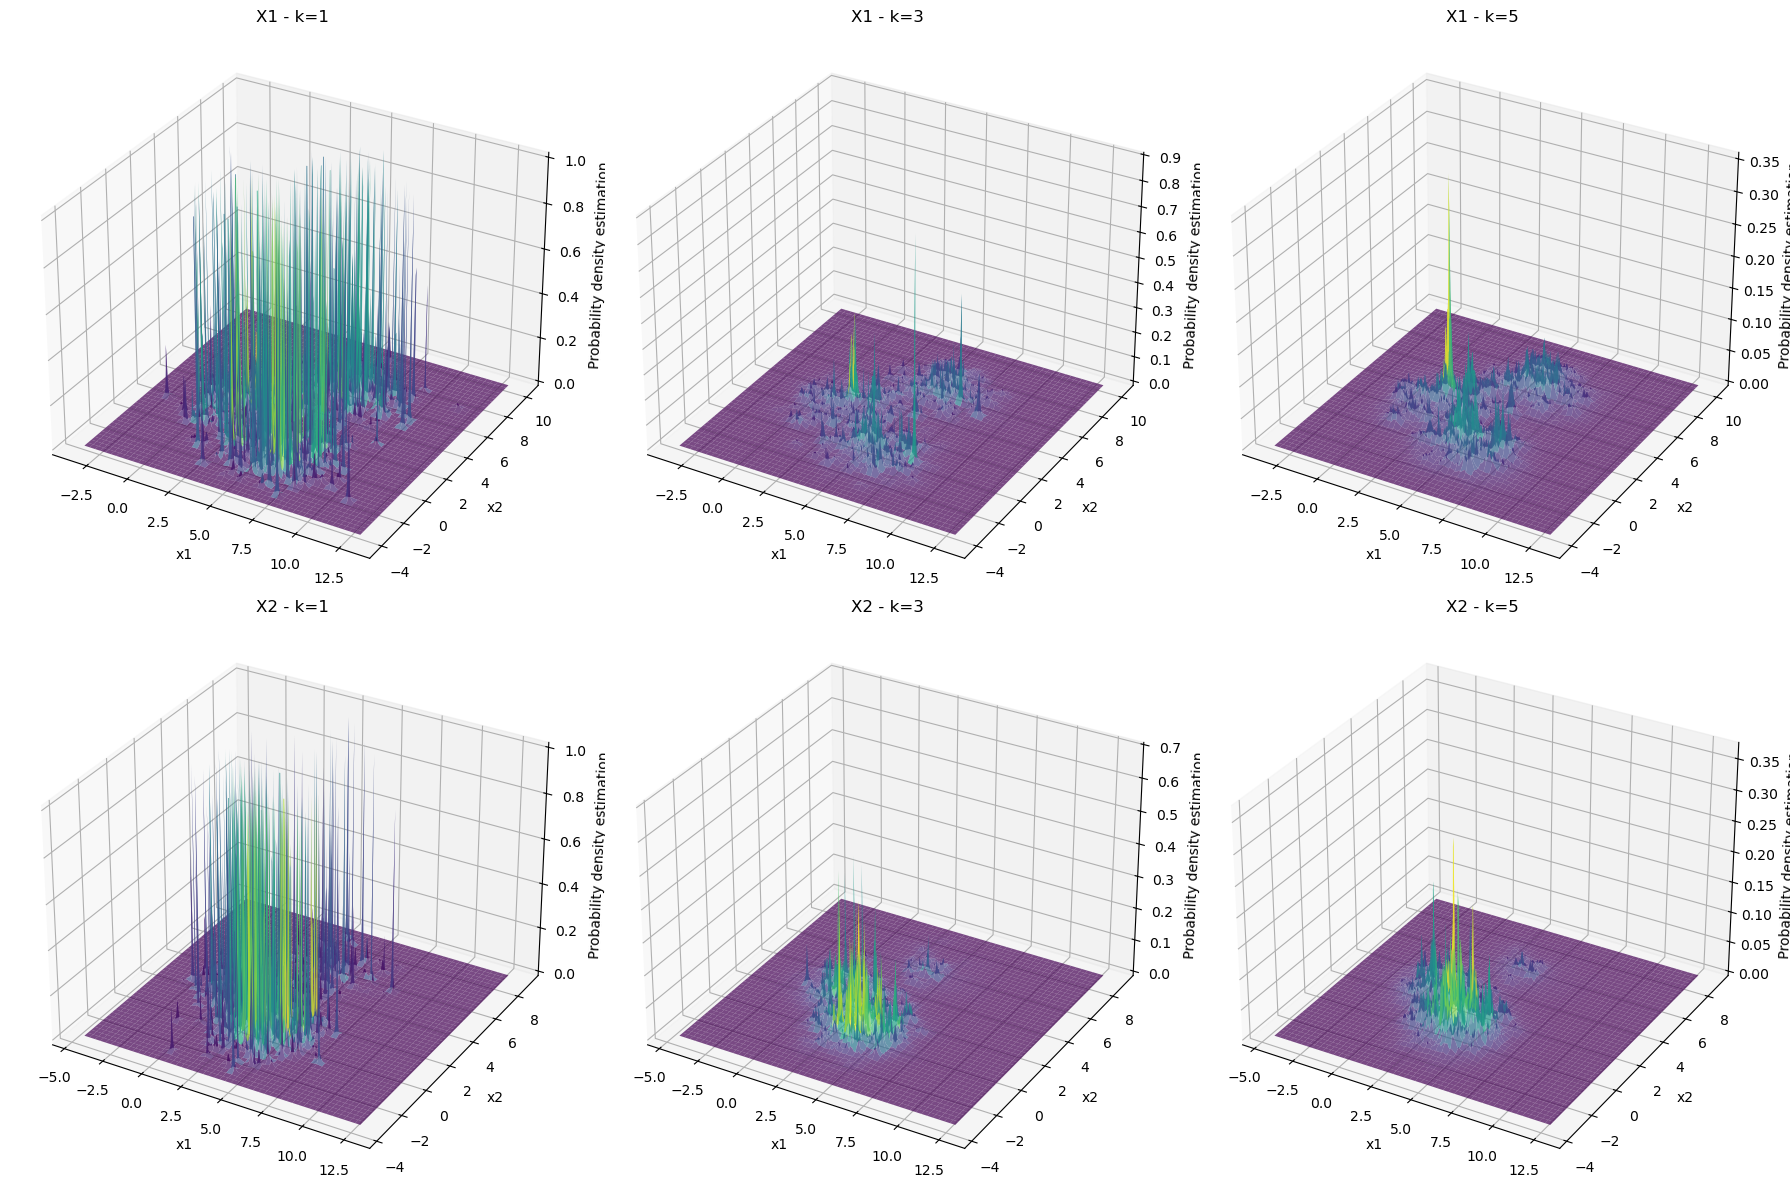

In [5]:
# knn概率密度估计函数
def knn_density_estimate(X, k, grid_x, grid_y):
    n = X.shape[0]
    # 创建网格点坐标
    grid_points = np.array([[gx, gy] for gx in grid_x for gy in grid_y])
    # 找到最近的第k个点的距离和索引，用这个点计算面积
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(grid_points)
    volumes = (np.pi * distances[:, k - 1] ** 2)
    # P = k/nS
    density_estimates = np.zeros(len(grid_points))
    density_estimates[distances[:, k - 1] == 0] = 1
    non_zero_volumes = volumes > 0
    density_estimates[non_zero_volumes] = k / (n * volumes[non_zero_volumes]) 
    density_estimates[density_estimates > 1] = 1
    return grid_points, density_estimates

# 预设 k 值
k_values = [1, 3, 5]
num_distributions = 3

# 概率密度可视化
fig = plt.figure(figsize=(18, 12))

# 创建网格
x_min_X1, x_max_X1 = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min_X1, y_max_X1 = X1[:, 1].min() - 1, X1[:, 1].max() + 1
x_min_X2, x_max_X2 = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min_X2, y_max_X2 = X2[:, 1].min() - 1, X2[:, 1].max() + 1

grid_x_X1 = np.linspace(x_min_X1, x_max_X1, 500)
grid_y_X1 = np.linspace(y_min_X1, y_max_X1, 500)

grid_x_X2 = np.linspace(x_min_X2, x_max_X2, 500)
grid_y_X2 = np.linspace(y_min_X2, y_max_X2, 500)

for j, k in enumerate(k_values):

    # 绘制 X1 数据集的概率密度分布图
    ax1 = fig.add_subplot(2, 3, j + 1, projection='3d')
    grid_points, density_X1 = knn_density_estimate(X1, k, grid_x_X1, grid_y_X1)
    grid_xx, grid_yy = np.meshgrid(grid_x_X1, grid_y_X1)
    density_surface_X1 = density_X1.reshape((len(grid_x_X1), len(grid_y_X1)))
    ax1.plot_surface(grid_xx, grid_yy, density_surface_X1, cmap='viridis', alpha=0.7)
    ax1.set_title(f'X1 - k={k}')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_zlabel('Probability density estimation')

    # 绘制 X2 数据集的概率密度分布图
    ax2 = fig.add_subplot(2, 3, j + 4, projection='3d')
    grid_points, density_X2 = knn_density_estimate(X2, k, grid_x_X2, grid_x_X2)
    grid_xx, grid_yy = np.meshgrid(grid_x_X2, grid_y_X2)
    density_surface_X2 = density_X2.reshape((len(grid_x_X2), len(grid_x_X2)))
    ax2.plot_surface(grid_xx, grid_yy, density_surface_X2, cmap='viridis', alpha=0.7)
    ax2.set_title(f'X2 - k={k}')
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.set_zlabel('Probability density estimation')

plt.tight_layout()
plt.show()

由图中可以直观的看到不同数据点的概率密度，例如，对于$X_1$，概率密度较高的点均匀地分布在三个分布的均值点附近；对于$X_2$，由于均值为$(1,4)$的分布的先验概率为$\frac{1}{6}$，所以概率密度较高的点几乎集中在了这一均值附近。对于$k=1$，可以看出其不连续点较多，显然不是一种特别好的取值。